In [1]:
import tensorflow as tf

class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute 1st and 2nd derivatives for the 2D wave equation.

    Attributes:
        model: keras network model.
    """

    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """
        self.model = model
        super().__init__(**kwargs)

    def call(self, txy):
        """
        Computing 1st and 2nd derivatives for the 2D wave equation.

        Args:
            txy: input variables (t, x, y).

        Returns:
            u: network output.
            du_dt: 1st derivative of t.
            du_dx: 1st derivative of x.
            du_dy: 1st derivative of y.
            d2u_dt2: 2nd derivative of t.
            d2u_dx2: 2nd derivative of x.
            d2u_dy2: 2nd derivative of y.
        """

        with tf.GradientTape() as g:
            g.watch(txy)
            with tf.GradientTape() as gg:
                gg.watch(txy)
                u = self.model(txy)
            du_dtx = gg.batch_jacobian(u, txy)
            du_dt = du_dtx[..., 0]   # Derivative with respect to t
            du_dx = du_dtx[..., 1]   # Derivative with respect to x
            du_dy = du_dtx[..., 2]   # Derivative with respect to y

        d2u_dtx2 = g.batch_jacobian(du_dtx, txy)
        d2u_dt2 = d2u_dtx2[..., 0, 0]  # 2nd derivative with respect to t
        d2u_dx2 = d2u_dtx2[..., 1, 1]  # 2nd derivative with respect to x
        d2u_dy2 = d2u_dtx2[..., 2, 2]  # 2nd derivative with respect to y

        return u, du_dt, du_dx, du_dy, d2u_dt2, d2u_dx2, d2u_dy2

In [2]:
import tensorflow as tf

class Network:
    """
    Build a physics informed neural network (PINN) model for the wave equation.
    """

    @classmethod
    def build(cls, num_inputs=3, layers=[32, 16, 32], activation='tanh', num_outputs=1):
        """
        Build a PINN model for the wave equation with input shape (t, x) and output shape u(t, x).

        Args:
            num_inputs: number of input variables. Default is 2 for (t, x).
            layers: number of hidden layers.
            activation: activation function in hidden layers.
            num_outpus: number of output variables. Default is 1 for u(t, x).

        Returns:
            keras network model.
        """

        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation,
                kernel_initializer='he_normal')(x)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(x)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [3]:
import scipy.optimize
import numpy as np
import tensorflow as tf

class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.

    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: logging metrics.
        progbar: progress bar.
    """

    def __init__(self, model, x_train, y_train, factr=1e5, m=50, maxls=50, maxiter=15000):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger()
        # self.progbar = tf.keras.callbacks.ProgbarLogger(
        #     count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.

        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.

        Args:
            x: input data.

        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.

        Args:
            weights: flatten weights.

        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.

        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

In [4]:
import tensorflow as tf


class PINN:
    """
    Build a physics informed neural network (PINN) model for the wave equation.

    Attributes:
        network: keras network model with input (t, x) and output u(t, x).
        c: wave velocity.
        grads: gradient layer.
    """

    def __init__(self, network, c=1):
        """
        Args:
            network: keras network model with input (t, x) and output u(t, x).
            c: wave velocity. Default is 1.
        """

        self.network = network
        self.c = c
        self.grads = GradientLayer(self.network)

    def build(self):


        # equation input: (t, x, y)
        txy_eqn = tf.keras.layers.Input(shape=(3,))
        # initial condition input: (t=0, x,y)
        txy_ini = tf.keras.layers.Input(shape=(3,))
        # boundary condition input: (t, x, y=-1) or (t, x, y=+1) for y-boundaries, same for x
        txy_bnd = tf.keras.layers.Input(shape=(3,))

        # compute gradients (u, du_dt, du_dx, du_dy, d2u_dt2, d2u_dx2, d2u_dy2)
        u_eqn, _, _, _, d2u_dt2, d2u_dx2, d2u_dy2 = self.grads(txy_eqn)

        # equation output should satisfy the 2D wave equation: u_tt = c^2 (u_xx + u_yy)
        u_eqn = d2u_dt2 - self.c * self.c * (d2u_dx2 + d2u_dy2)

        # initial condition output
        u_ini, du_dt_ini, _, _, _, _, _ = self.grads(txy_ini)

        # boundary condition output
        u_bnd = self.network(txy_bnd)  # Dirichlet boundary condition
        # _, _, _, _, _, _, u_bnd = self.grads(txy_bnd)  # Neumann boundary condition

        # build the PINN model for the 2D wave equation
        return tf.keras.models.Model(
            inputs=[txy_eqn, txy_ini, txy_bnd],
            outputs=[u_eqn, u_ini, du_dt_ini, u_bnd]
        )

In [5]:
# suppress tensorflow warnings (must be called before importing tensorflow)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf

def u0(txy, c=1, k=2, sd=0.5):
    t = txy[..., 0, None]  # Time variable
    x = txy[..., 1, None]  # X spatial variable
    y = txy[..., 2, None]  # Y spatial variable

    # Convert Cartesian coordinates (x, y) to radial distance (r)
    r = tf.sqrt(x**2 + y**2)  # Radial distance from origin

    # Calculate the circular wave function
    z = k * r - (c * k) * t  # Wave propagating outward in a circular manner
    return tf.sin(z) * tf.exp(-(0.5 * z / sd) ** 2)

def du0_dt(txy):
    with tf.GradientTape() as g:
        g.watch(txy)
        u = u0(txy)
    du_dt = g.batch_jacobian(u, txy)[..., 0]  # Get the derivative w.r.t. time
    return du_dt


In [8]:
# number of training samples
num_train_samples = 1000
# number of test samples
num_test_samples = 500
# build a core network model
network = Network.build()
network.summary()
    # build a PINN model
pinn = PINN(network).build()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,233 (4.82 KB)

 Trainable params: 1,233 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# create training input
txy_eqn = np.random.rand(num_train_samples, 3)
txy_eqn[..., 0] = 4 * txy_eqn[..., 0]                # t = 0 ~ +4
txy_eqn[..., 1] = 2 * txy_eqn[..., 1] - 1            # x = -1 ~ +1
txy_eqn[..., 2] = 2 * txy_eqn[..., 2] - 1            # y = -1 ~ +1

txy_ini = np.random.rand(num_train_samples, 3)
txy_ini[..., 0] = 0                                  # t = 0 (initial time)
txy_ini[..., 1] = 2 * txy_ini[..., 1] - 1            # x = -1 ~ +1
txy_ini[..., 2] = 2 * txy_ini[..., 2] - 1            # y = -1 ~ +1

txy_bnd = np.random.rand(num_train_samples, 3)
txy_bnd[..., 0] = 4 * txy_bnd[..., 0]                # t = 0 ~ +4
txy_bnd[..., 1] = 2 * np.round(txy_bnd[..., 1]) - 1  # x = -1 or +1 (boundary in x)
txy_bnd[..., 2] = 2 * np.round(txy_bnd[..., 2]) - 1  # y = -1 or +1 (boundary in y)

# create training output
u_zero = np.zeros((num_train_samples, 1))            # Output for zero solutions
u_ini = u0(tf.constant(txy_ini)).numpy()             # Initial condition output u(t=0, x, y)
du_dt_ini = du0_dt(tf.constant(txy_ini)).numpy()     # Initial time derivative du/dt (t=0, x, y)

In [10]:
# train the model using L-BFGS-B algorithm
# Update x_train to include txy (t, x, y) inputs
x_train = [txy_eqn, txy_ini, txy_bnd]
y_train = [u_zero, u_ini, du_dt_ini, u_zero]

# Train the model using L-BFGS-B optimizer
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

# Predict u(t, x, y) distribution
t_flat = np.linspace(0, 4, num_test_samples)    # Time dimension
x_flat = np.linspace(-1, 1, num_test_samples)   # X dimension
y_flat = np.linspace(-1, 1, num_test_samples)   # Y dimension

# Create meshgrid for t, x, and y
t, x, y = np.meshgrid(t_flat, x_flat, y_flat)

# Prepare input for prediction
txy = np.stack([t.flatten(), x.flatten(), y.flatten()], axis=-1)


# Make predictions using the trained model
u = network.predict(txy, batch_size=num_test_samples)
u = u.reshape(t.shape)  # Reshape to match the t, x, y grid shape

Optimizer: L-BFGS-B (maxiter=15000)
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 189s 13ms/step
250000/250000 ━━━━━━━━━━━━━━━━━━━━ 344s 1ms/step


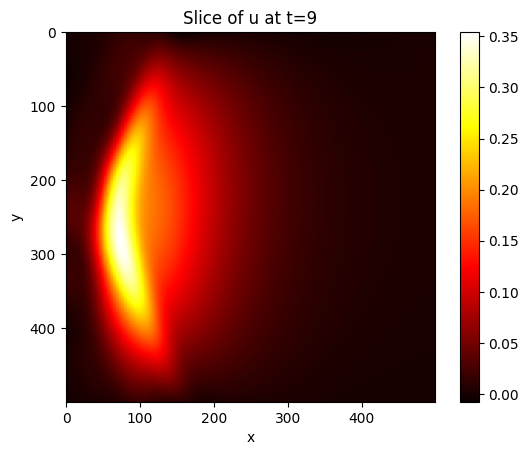

In [11]:
# Choose a particular value of t
t_index = 9

# Extract the (x, y) slice for the chosen t value
u_slice = u[:, :, t_index]

plt.imshow(u_slice, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Slice of u at t={t_index}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

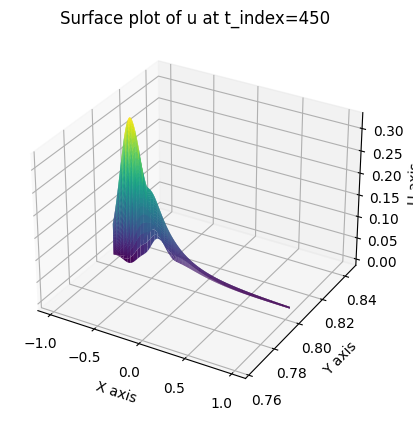

In [12]:
# Create a surface plot for the chosen t value
t_index = 450

# Extract the (x, y) slice for the chosen t value
u_slice = u[t_index, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x[:, t_index, :], y[:, :, t_index], u_slice, cmap='viridis')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('U axis')
ax.set_title(f'Surface plot of u at t_index={t_index}')

plt.show()